In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure
from sklearn import (
    preprocessing, 
    neighbors, 
    decomposition,
    cluster, 
    metrics, 
    model_selection,
    pipeline,
)
from pathlib import Path

In [2]:
def load(path):
    file_names = sorted(Path(path).glob("*.TIF"))
    bands = [2.75e-05 * skimage.io.imread(f).astype("float32") - 0.2 for f in file_names]
    #bands = [skimage.exposure.rescale_intensity(b, in_range=(-0.1, 1)) for b in bands]
    return bands

In [3]:
before = load("src/remote-sensing/data/thomas_fire/LC08_L2SP_042036_20171123_20200902_02_T1_cropped/")
after = load("src/remote-sensing/data/thomas_fire/LC08_L2SP_042036_20180126_20200902_02_T1_cropped/")
diff = [a - b for a, b in zip(after, before)]

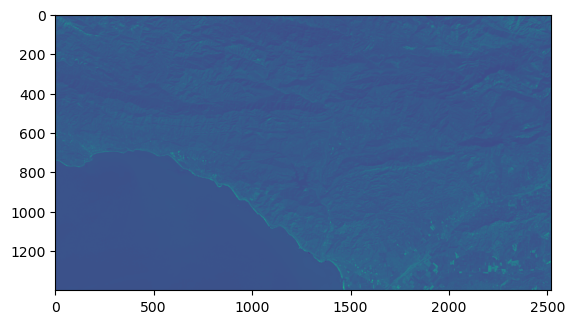

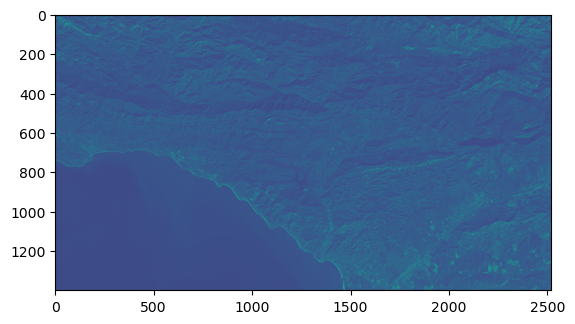

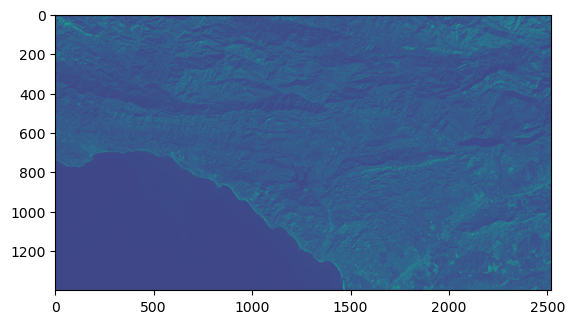

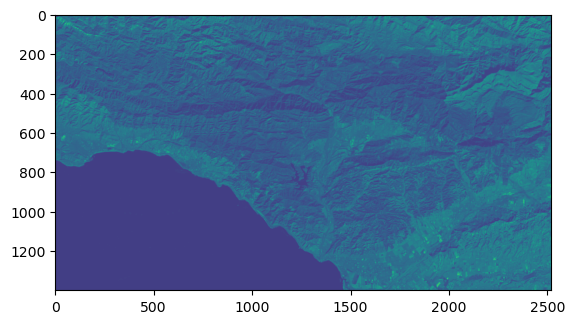

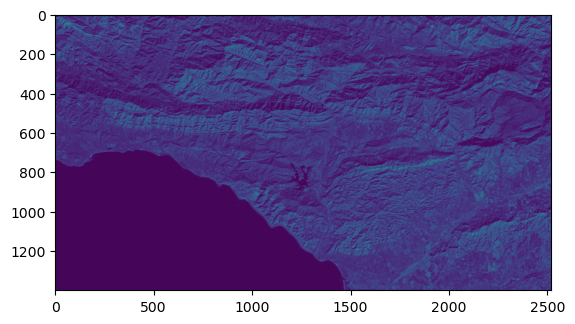

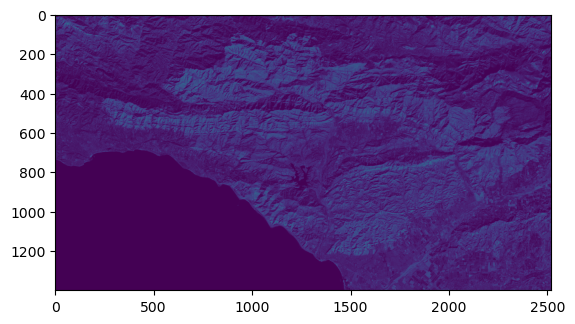

In [4]:
for band in after:
    plt.figure()
    plt.imshow(band)

In [5]:
features = pd.DataFrame({f"band_{i + 2}": b.ravel() for i, b in enumerate(after)})
features

,band_2,band_3,band_4,band_5,band_6,band_7
0,0.015243,0.023162,0.023520,0.085560,0.074918,0.056438
1,0.018955,0.027865,0.033695,0.099805,0.092022,0.065980
2,0.022090,0.033090,0.040130,0.093480,0.094360,0.066420
3,0.024290,0.037518,0.044227,0.090400,0.086467,0.061745
4,0.014527,0.021650,0.024895,0.054017,0.047857,0.032458
...,...,...,...,...,...,...
3527995,0.058885,0.093012,0.129202,0.346618,0.297503,0.187228
3527996,0.047885,0.080115,0.100300,0.297448,0.251468,0.154970
3527997,0.040267,0.063202,0.067382,0.279188,0.164292,0.108578
3527998,0.038617,0.068400,0.073845,0.275530,0.203397,0.134455


In [23]:
%%time
X = preprocessing.StandardScaler().fit_transform(features)
km = cluster.KMeans(n_clusters=5, random_state=0).fit(X)
features["labels"] = km.predict(X)

CPU times: user 4min 14s, sys: 2min 8s, total: 6min 22s
Wall time: 13.5 s


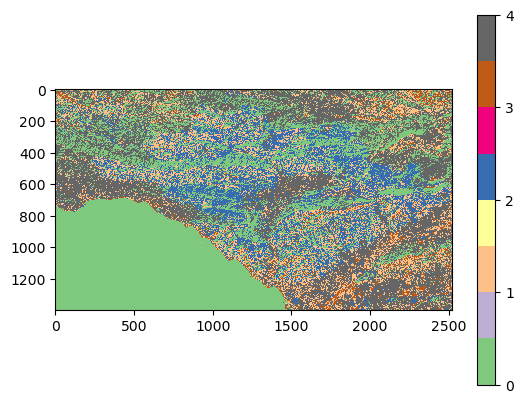

In [24]:
plt.imshow(features.labels.values.reshape(diff[0].shape), cmap="Accent", interpolation="none")
plt.colorbar(ticks=np.arange(km.n_clusters))

<AxesSubplot: >

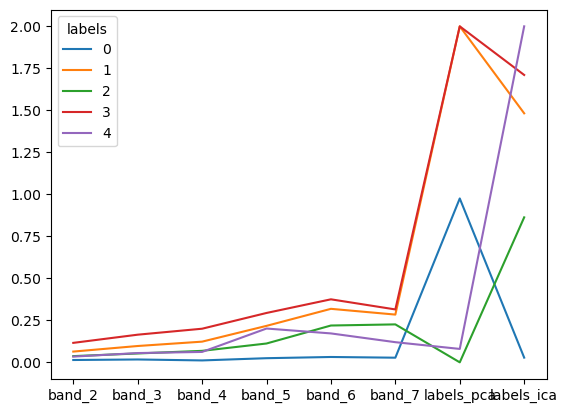

In [25]:
features.groupby("labels").mean().T.plot()

[0.66130902 0.87588341 0.93798308 0.97459717 0.98880652 0.99519752
 0.998256   0.9992741  1.        ]


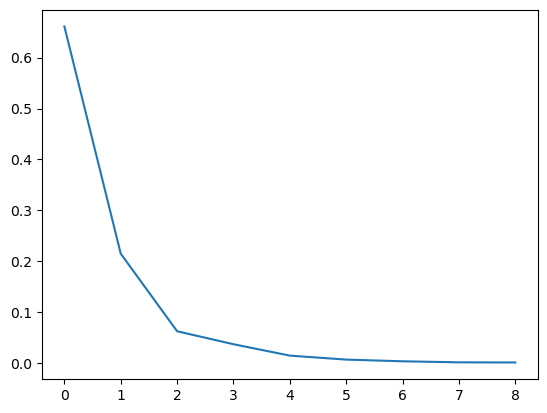

In [27]:
pca = decomposition.PCA().fit(preprocessing.StandardScaler().fit_transform(features))
print(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)

In [47]:
%%time
X = features.values
X = preprocessing.StandardScaler().fit_transform(X)
X = decomposition.PCA(n_components=3).fit_transform(X)
X

CPU times: user 39 s, sys: 31.5 s, total: 1min 10s
Wall time: 5.49 s


array([[-2.30531034,  0.43277963,  0.10947602],
       [-2.01237861,  0.49527387,  0.1986956 ],
       [-1.88697834,  0.58882899,  0.33351319],
       ...,
       [ 1.25198248, -1.66920339,  0.4780574 ],
       [ 1.50412927, -1.54428916,  0.27992581],
       [ 1.56018451, -1.25366626,  0.57285923]])

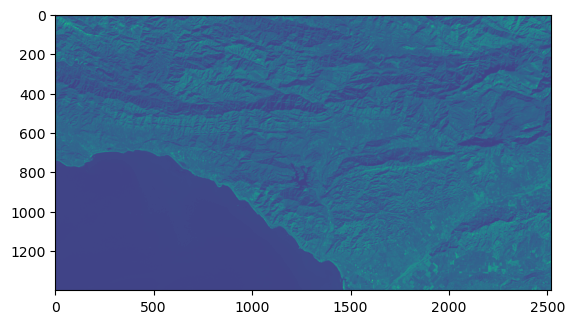

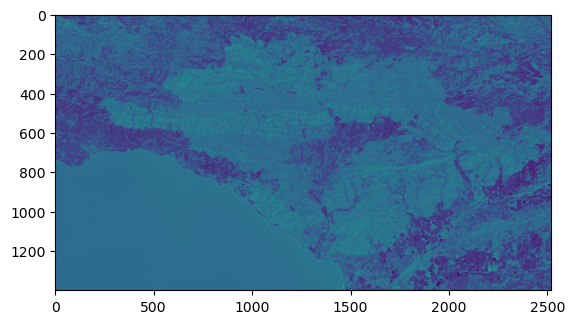

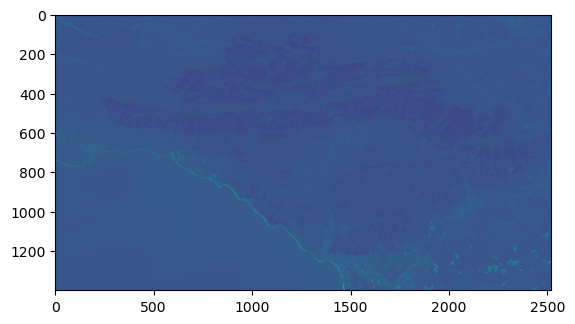

In [48]:
for comp in X.T:
    plt.figure()
    plt.imshow(comp.reshape(diff[0].shape))

In [52]:
%%time
km_pca = cluster.KMeans(n_clusters=4, random_state=0).fit(X)
features["labels_pca"] = km_pca.predict(X)

CPU times: user 2min 19s, sys: 1min 28s, total: 3min 47s
Wall time: 7.85 s


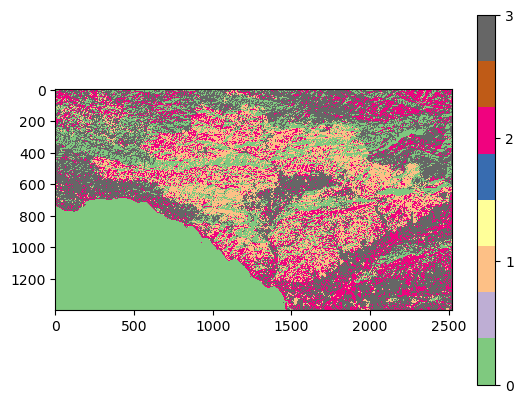

In [53]:
plt.imshow(features.labels_pca.values.reshape(diff[0].shape), cmap="Accent", interpolation="none")
plt.colorbar(ticks=np.arange(km_pca.n_clusters))

<AxesSubplot: >

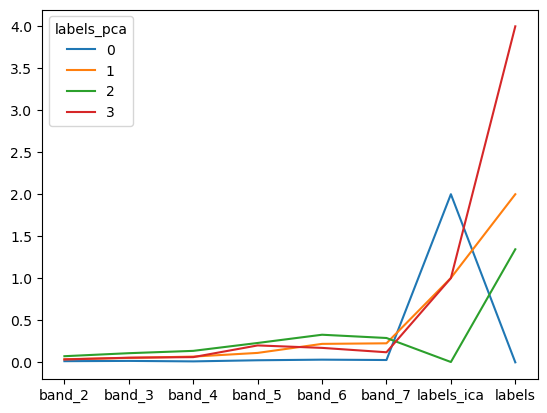

In [54]:
features.groupby("labels_pca").mean().T.plot()

In [55]:
%%time
Xica = decomposition.FastICA(random_state=0, whiten="unit-variance").fit_transform(X)

CPU times: user 27.7 s, sys: 24.8 s, total: 52.5 s
Wall time: 2.47 s


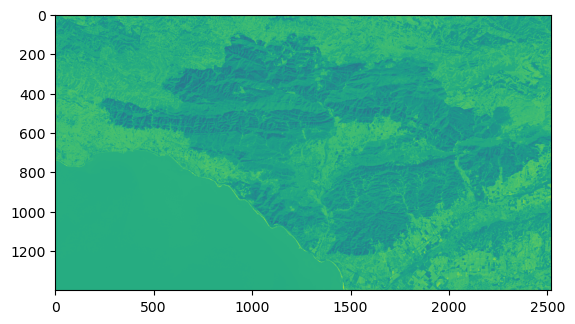

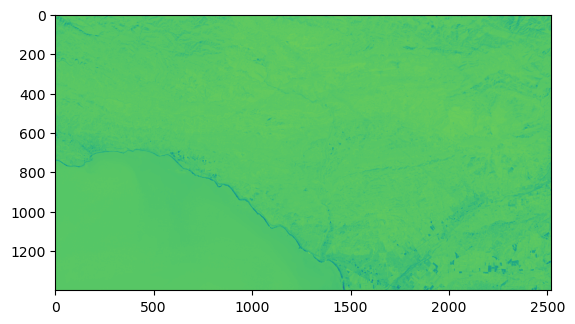

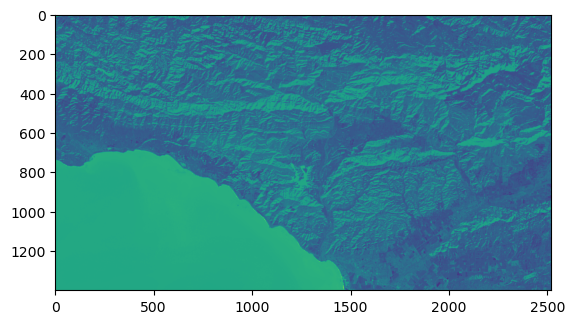

In [56]:
for comp in Xica.T:
    plt.figure()
    plt.imshow(comp.reshape(diff[0].shape))

In [60]:
%%time
km_ica = cluster.KMeans(n_clusters=4, random_state=0).fit(Xica)
features["labels_ica"] = km_ica.predict(Xica)

CPU times: user 3min 39s, sys: 2min, total: 5min 39s
Wall time: 11.2 s


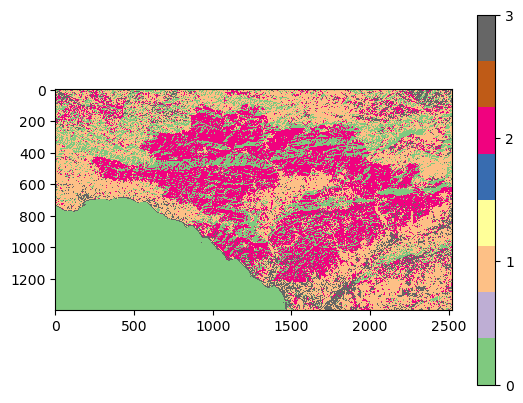

In [61]:
plt.imshow(features.labels_ica.values.reshape(diff[0].shape), cmap="Accent", interpolation="none")
plt.colorbar(ticks=np.arange(km_ica.n_clusters))

<AxesSubplot: >

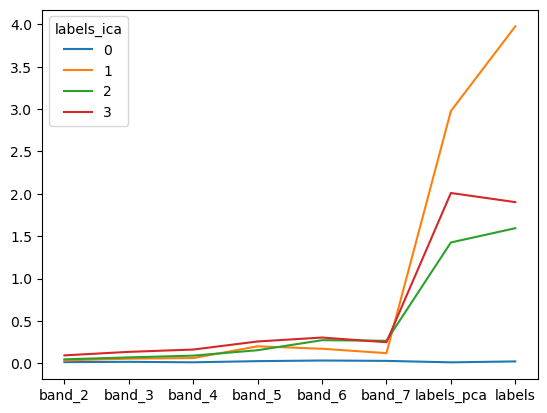

In [62]:
features.groupby("labels_ica").mean().T.plot()

In [17]:
np.sum(features.labels_ica == 0) * 30**2 * 1e-6 * 247.10538161

312743.19338984316